# Modelo robusto

[Fonte: storopoli](https://storopoli.github.io/Bayesian-Julia/pages/11_multilevel_models/)

In [6]:
# Pacotes necessários
import Pkg
#Pkg.add("StatsPlots")
#Pkg.add("Distributions")
#Pkg.add("LaTeXStrings")
#Pkg.add("DataFrames")

In [7]:
# Carregar pacotes
using StatsPlots, Distributions, LaTeXStrings, DataFrames

# Bayesian Robust Regression

In [8]:
# Instalar pacotes necessários
#Pkg.add("Turing")
#Pkg.add("StatsBase")

In [9]:
# Carregar pacotes
using Turing
using Statistics: mean, std
using StatsBase: mad
using Random: seed!

In [10]:
# Travar seed
seed!(123)

Random.TaskLocalRNG()

In [11]:
# Modelo
@model function robustreg(X, y; predictors=size(X, 2))
        #priors
        α ~ LocationScale(median(y), 2.5 * mad(y), TDist(3))
        β ~ filldist(TDist(3), predictors)
        σ ~ Exponential(1)
        ν ~ LogNormal(2, 1)

        #likelihood
        y ~ arraydist(LocationScale.(α .+ X * β, σ, TDist.(ν)))
end;

In [26]:
using DataFrames, CSV, HTTP

url = "https://raw.githubusercontent.com/andrelmfsantos/df/main/dataset_brands_quarter.csv"
data = CSV.read(HTTP.get(url).body, DataFrame)
println(first(data,5))
describe(data)

5×10 DataFrame
 Row │ Brand    Date     Spends       Maco         Causals      Volume       CPM          EFF          ROI          P1      
     │ String7  String7  String15     String15     String15     String15     String15     String15     String15     String7 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Brand1   2021Q2   169821,1753  163531,3699  194584616,5  8086,634834  0,872736902  0,041558449  0,962962184  0,1
   2 │ Brand1   2021Q3   143799,355   160621,3444  211758072    7942,733919  0,679073783  0,03750853   1,11698237   0,35
   3 │ Brand1   2021Q4   9380,317164  11781,89926  8984931      582,6155375  1,044005476  0,06484363   1,25602355   0,016
   4 │ Brand1   2022Q1   107989,1762  132402,2698  166748726    7052,467539  0,647616199  0,042293982  1,22606982   0,06409
   5 │ Brand2   2021Q2   578302,51    750449,6574  673866619,3  23723,32076  0,858185423  0,035204772  1,297676639  0,03


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Nothing,InlineSt…,Nothing,InlineSt…,Int64,DataType
1,Brand,,Brand1,,Brand6,0,String7
2,Date,,2021Q2,,2022Q3,0,String7
3,Spends,,"1069170,659",,"971247,7588",0,String15
4,Maco,,"1008106,291",,"970228,9512",0,String15
5,Causals,,1018476095,,973531058,0,String15
6,Volume,,"114101,3444",,"8086,634834",0,String15
7,CPM,,"0,618921733",,"1,720402461",0,String15
8,EFF,,"0,015460916",,"0,079763334",0,String15
9,ROI,,"0,811409181",,"2,553092326",0,String15


In [18]:
# Substituir nas casas decimais, vírgula por pontos
df = replace.(data, r"," => ".")
println(first(df,5))

5×10 DataFrame
 Row │ Brand   Quarter  Spends       Maco         Causals      Volume       CPM          EFF          ROI          P1      
     │ String  String   String       String       String       String       String       String       String       String  
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Brand1  2021Q2   169821.1753  163531.3699  194584616.5  8086.634834  0.872736902  0.041558449  0.962962184  0.10000
   2 │ Brand1  2021Q3   143799.355   160621.3444  211758072    7942.733919  0.679073783  0.03750853   1.11698237   0.35000
   3 │ Brand1  2021Q4   9380.317164  11781.89926  8984931      582.6155375  1.044005476  0.06484363   1.25602355   0.01600
   4 │ Brand1  2022Q1   107989.1762  132402.2698  166748726    7052.467539  0.647616199  0.042293982  1.22606982   0.06409
   5 │ Brand2  2021Q2   578302.51    750449.6574  673866619.3  23723.32076  0.858185423  0.035204772  1.297676639  0.0300

In [19]:
# Converter colunas para Float
df.Spends = parse.(Float64, df.Spends)
df.Maco = parse.(Float64, df.Maco)
df.Causals = parse.(Float64, df.Causals)
df.Volume = parse.(Float64, df.Volume)
df.CPM = parse.(Float64, df.CPM)
df.EFF = parse.(Float64, df.EFF)
df.ROI = parse.(Float64, df.ROI)
df.P1 = parse.(Float64, df.P1)
println(first(df,5))

5×10 DataFrame
 Row │ Brand   Quarter  Spends        Maco           Causals    Volume     CPM       EFF        ROI       P1      
     │ String  String   Float64       Float64        Float64    Float64    Float64   Float64    Float64   Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Brand1  2021Q2      1.69821e5      1.63531e5  1.94585e8   8086.63   0.872737  0.0415584  0.962962  0.1
   2 │ Brand1  2021Q3      1.43799e5      1.60621e5  2.11758e8   7942.73   0.679074  0.0375085  1.11698   0.35
   3 │ Brand1  2021Q4   9380.32       11781.9        8.98493e6    582.616  1.04401   0.0648436  1.25602   0.016
   4 │ Brand1  2022Q1      1.07989e5      1.32402e5  1.66749e8   7052.47   0.647616  0.042294   1.22607   0.06409
   5 │ Brand2  2021Q2      5.78303e5      7.5045e5   6.73867e8  23723.3    0.858185  0.0352048  1.29768   0.03


In [21]:
# Subset
df = df[!, names(data,[:Brand,:P1,:CPM, :EFF, :ROI])]
show(df, allcols=true)

34×5 DataFrame
 Row │ Brand   P1       CPM       EFF        ROI      
     │ String  Float64  Float64   Float64    Float64  
─────┼────────────────────────────────────────────────
   1 │ Brand1  0.1      0.872737  0.0415584  0.962962
   2 │ Brand1  0.35     0.679074  0.0375085  1.11698
   3 │ Brand1  0.016    1.04401   0.0648436  1.25602
   4 │ Brand1  0.06409  0.647616  0.042294   1.22607
   5 │ Brand2  0.03     0.858185  0.0352048  1.29768
   6 │ Brand2  0.22     0.914811  0.0282665  0.977433
   7 │ Brand2  0.19     0.929766  0.0377981  1.286
   8 │ Brand2  0.21522  0.732858  0.0408773  1.72349
   9 │ Brand2  0.38464  1.03367   0.0485312  1.35275
  10 │ Brand2  0.52094  0.926681  0.0433663  1.37547
  11 │ Brand3  0.11     0.80446   0.0386498  1.88737
  ⋮  │   ⋮        ⋮        ⋮          ⋮         ⋮
  25 │ Brand5  0.27     0.980993  0.0605435  1.48892
  26 │ Brand5  0.17014  0.909776  0.064062   1.60076
  27 │ Brand5  0.39435  0.756733  0.0698154  1.89279
  28 │ Brand5  0.50193  0.86

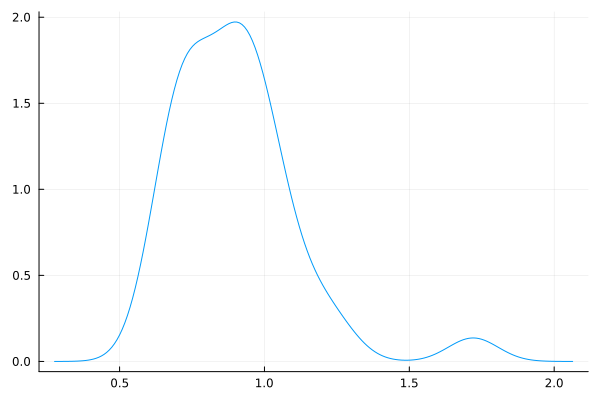

In [22]:
# Densidade
@df df density(:CPM, label=false)

In [23]:
# Instanciar os dados
X = Matrix(select(df, [:P1]))
y = df[:, :CPM]
model = robustreg(X, y);

In [24]:
# Cadeias de Markov
chain = sample(model, NUTS(), MCMCThreads(), 1_000, 4)
#summarystats(chain)
#show(summarystats(chain), allcols=true)
DataFrame(summarystats(chain))

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\fnRmh\src\sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:01


,parameters,mean,std,naive_se,mcse,ess,rhat,ess_per_sec
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,α,0.901491,0.0610779,0.000965726,0.0011011,2166.78,1.00071,115.328
2,β[1],-0.0975678,0.207852,0.00328644,0.00363364,2171.48,1.00059,115.578
3,σ,0.170296,0.0314087,0.000496616,0.000572989,2662.46,1.00028,141.711
4,ν,8.13715,9.18322,0.145199,0.184087,1747.55,0.9995,93.0142


# Multilevel

In [61]:
# Base
# Substituir nas casas decimais, vírgula por pontos
df = replace.(data, r"," => ".")
# Converter colunas para Float
df.Spends = parse.(Float64, df.Spends)
df.Maco = parse.(Float64, df.Maco)
df.Causals = parse.(Float64, df.Causals)
df.Volume = parse.(Float64, df.Volume)
df.CPM = parse.(Float64, df.CPM)
df.EFF = parse.(Float64, df.EFF)
df.ROI = parse.(Float64, df.ROI)
df.P1 = parse.(Float64, df.P1)
# Subset
df = df[!, names(data,[:Brand,:Date,:P1,:CPM, :EFF, :ROI])]

show(df, allcols=true)

34×4 DataFrame
 Row │ Brand   Date    P1       CPM      
     │ String  String  Float64  Float64  
─────┼───────────────────────────────────
   1 │ Brand1  2021Q2  0.1      0.872737
   2 │ Brand1  2021Q3  0.35     0.679074
   3 │ Brand1  2021Q4  0.016    1.04401
   4 │ Brand1  2022Q1  0.06409  0.647616
   5 │ Brand2  2021Q2  0.03     0.858185
   6 │ Brand2  2021Q3  0.22     0.914811
   7 │ Brand2  2021Q4  0.19     0.929766
   8 │ Brand2  2022Q1  0.21522  0.732858
   9 │ Brand2  2022Q2  0.38464  1.03367
  10 │ Brand2  2022Q3  0.52094  0.926681
  11 │ Brand3  2021Q2  0.11     0.80446
  ⋮  │   ⋮       ⋮        ⋮        ⋮
  25 │ Brand5  2021Q4  0.27     0.980993
  26 │ Brand5  2022Q1  0.17014  0.909776
  27 │ Brand5  2022Q2  0.39435  0.756733
  28 │ Brand5  2022Q3  0.50193  0.861372
  29 │ Brand6  2022Q3  0.18061  1.12074
  30 │ Brand6  2021Q2  0.13     0.935055
  31 │ Brand6  2021Q3  0.13     0.801697
  32 │ Brand6  2021Q4  0.27     1.7204
  33 │ Brand6  2022Q1  0.25847  0.925099
  34 │ B

In [62]:
# Nova coluna com quarter
df = hcat(df, DataFrame(reduce(vcat, permutedims.(split.(df.Date, 'Q'))), [:Year, :Quarter]))
df

,Brand,Date,P1,CPM,Year,Quarter
,String,String,Float64,Float64,SubStrin…,SubStrin…
1,Brand1,2021Q2,0.1,0.872737,2021,2
2,Brand1,2021Q3,0.35,0.679074,2021,3
3,Brand1,2021Q4,0.016,1.04401,2021,4
4,Brand1,2022Q1,0.06409,0.647616,2022,1
5,Brand2,2021Q2,0.03,0.858185,2021,2
6,Brand2,2021Q3,0.22,0.914811,2021,3
7,Brand2,2021Q4,0.19,0.929766,2021,4
8,Brand2,2022Q1,0.21522,0.732858,2022,1
9,Brand2,2022Q2,0.38464,1.03367,2022,2


In [63]:
for c in unique(df[:, :Brand])
    df[:, "Brand_$c"] = ifelse.(df[:, :Brand] .== c, 1, 0)
end

df[:, :Quarter_int] = map(df[:, :Quarter]) do b
    b == "1" ? 1 :
    b == "2" ? 2 :
    b == "3" ? 3 :
    b == "4" ? 4 : missing
end

show(df, allcols=true)

34×13 DataFrame
 Row │ Brand   Date    P1       CPM       Year       Quarter    Brand_Brand1  Brand_Brand2  Brand_Brand3  Brand_Brand4  Brand_Brand5  Brand_Brand6  Quarter_int 
     │ String  String  Float64  Float64   SubStrin…  SubStrin…  Int64         Int64         Int64         Int64         Int64         Int64         Int64       
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Brand1  2021Q2  0.1      0.872737  2021       2                     1             0             0             0             0             0            2
   2 │ Brand1  2021Q3  0.35     0.679074  2021       3                     1             0             0             0             0             0            3
   3 │ Brand1  2021Q4  0.016    1.04401   2021       4                     1             0             0             0             0             0            4
   4 │ Brand1  2022Q1

In [52]:
X = Matrix(select(df, Between(:Brand_Brand1, :Brand_Brand6)));
y = df[:, :CPM];
idx = df[:, :Quarter_int];

## Modelos

In [53]:
# Instalar pacotes necessários
#Pkg.add("Turing")
#Pkg.add("StatsBase")

In [54]:
using Turing
using LinearAlgebra: I
using Statistics: mean, std
using Random: seed!
seed!(123)

Random.TaskLocalRNG()

### 1 - Modelo de interceptação aleatória

In [55]:
# varying_intercept
@model function varying_intercept(X, idx, y; n_gr=length(unique(idx)), predictors=size(X, 2))
    #priors
    α ~ Normal(mean(y), 2.5 * std(y))       # population-level intercept
    β ~ filldist(Normal(0, 2), predictors)  # population-level coefficients
    σ ~ Exponential(1 / std(y))             # residual SD
    #prior for variance of random intercepts
    #usually requires thoughtful specification
    τ ~ truncated(Cauchy(0, 2); lower=0)    # group-level SDs intercepts
    αⱼ ~ filldist(Normal(0, τ), n_gr)       # group-level intercepts

    #likelihood
    ŷ = α .+ X * β .+ αⱼ[idx]
    y ~ MvNormal(ŷ, σ^2 * I)
end;

In [56]:
# varying_intercept
model_intercept = varying_intercept(X, idx, y)
chain_intercept = sample(model_intercept, NUTS(), MCMCThreads(), 1_000, 4)
summarystats(chain_intercept) |> DataFrame |> println

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\fnRmh\src\sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:11


13×8 DataFrame
 Row │ parameters  mean         std        naive_se     mcse         ess       rhat     ess_per_sec 
     │ Symbol      Float64      Float64    Float64      Float64      Float64   Float64  Float64     
─────┼──────────────────────────────────────────────────────────────────────────────────────────────
   1 │ α            0.929569    0.440693   0.00696797   0.0156687     715.411  1.00426      27.6284
   2 │ β[1]        -0.113746    0.459011   0.00725761   0.0163968     715.717  1.00427      27.6402
   3 │ β[2]        -0.00995174  0.457631   0.00723578   0.0165408     710.91   1.0037       27.4546
   4 │ β[3]         0.0952305   0.457759   0.0072378    0.016408      700.007  1.00397      27.0336
   5 │ β[4]        -0.16737     0.456917   0.00722449   0.0163533     704.495  1.00423      27.2069
   6 │ β[5]        -0.0830863   0.457032   0.00722631   0.0163567     708.95   1.00402      27.3789
   7 │ β[6]         0.17483     0.457531   0.00723421   0.0167136     707.692  1.0

### 2 - Modelo de inclinação aleatória

In [57]:
# varying_slope
@model function varying_slope(X, idx, y; n_gr=length(unique(idx)), predictors=size(X, 2))
    #priors
    α ~ Normal(mean(y), 2.5 * std(y))                    # population-level intercept
    σ ~ Exponential(1 / std(y))                          # residual SD
    #prior for variance of random slopes
    #usually requires thoughtful specification
    τ ~ filldist(truncated(Cauchy(0, 2); lower=0), n_gr) # group-level slopes SDs
    βⱼ ~ filldist(Normal(0, 1), predictors, n_gr)        # group-level standard normal slopes

    #likelihood
    ŷ = α .+ X * βⱼ * τ
    y ~ MvNormal(ŷ, σ^2 * I)
end;

In [58]:
model_slope = varying_slope(X, idx, y)
chain_slope = sample(model_slope, NUTS(), MCMCThreads(), 1_000, 4)
summarystats(chain_slope) |> DataFrame |> println

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\fnRmh\src\sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\User\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\User\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling (1 threads):  50%|███████████████              |  ETA: 0:00:04┌ Warning: The current proposal will be rejected du

30×8 DataFrame
 Row │ parameters  mean        std        naive_se     mcse        ess        rhat      ess_per_sec 
     │ Symbol      Float64     Float64    Float64      Float64     Float64    Float64   Float64     
─────┼──────────────────────────────────────────────────────────────────────────────────────────────
   1 │ α            0.872214   0.159163   0.00251658   0.00950559   166.596   1.0231       5.78259
   2 │ σ            0.20462    0.0306264  0.000484245  0.00163853   103.164   1.03465      3.58084
   3 │ τ[1]         0.143533   0.148669   0.00235066   0.00772421   131.95    1.03512      4.58001
   4 │ τ[2]         0.155922   0.143276   0.0022654    0.0052872    538.928   1.01335     18.7063
   5 │ τ[3]         0.216356   0.284498   0.00449831   0.0309131     23.9152  1.13483      0.830099
   6 │ τ[4]         0.174416   0.166378   0.00263067   0.0120369     79.1322  1.03269      2.74669
   7 │ βⱼ[1,1]      0.0339944  0.94318    0.014913     0.0393384    303.736   1.01392   

# 3 - Modelo de inclinação de interceptação aleatória

In [59]:
# varying_intercept_slope
@model function varying_intercept_slope(X, idx, y; n_gr=length(unique(idx)), predictors=size(X, 2))
    #priors
    α ~ Normal(mean(y), 2.5 * std(y))                     # population-level intercept
    σ ~ Exponential(1 / std(y))                           # residual SD
    #prior for variance of random intercepts and slopes
    #usually requires thoughtful specification
    τₐ ~ truncated(Cauchy(0, 2); lower=0)                 # group-level SDs intercepts
    τᵦ ~ filldist(truncated(Cauchy(0, 2); lower=0), n_gr) # group-level slopes SDs
    αⱼ ~ filldist(Normal(0, τₐ), n_gr)                    # group-level intercepts
    βⱼ ~ filldist(Normal(0, 1), predictors, n_gr)         # group-level standard normal slopes

    #likelihood
    ŷ = α .+ αⱼ[idx] .+ X * βⱼ * τᵦ
    y ~ MvNormal(ŷ, σ^2 * I)
end;

In [60]:
model_intercept_slope = varying_intercept_slope(X, idx, y)
chain_intercept_slope = sample(model_intercept_slope, NUTS(), MCMCThreads(), 1_000, 4)
summarystats(chain_intercept_slope) |> DataFrame |> println

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\fnRmh\src\sample.jl:291
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\User\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\User\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inf

35×8 DataFrame
 Row │ parameters  mean         std        naive_se     mcse        ess       rhat     ess_per_sec 
     │ Symbol      Float64      Float64    Float64      Float64     Float64   Float64  Float64     
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │ α            0.890824    0.217107   0.00343276   0.0134838    178.681  1.0228       3.68468
   2 │ σ            0.168871    0.0255902  0.000404616  0.0007015   1293.21   1.00064     26.6679
   3 │ τₐ           0.230795    0.214492   0.00339142   0.00932873   569.978  1.01087     11.7538
   4 │ τᵦ[1]        0.171856    0.167105   0.00264216   0.00541666   905.418  1.00553     18.6711
   5 │ τᵦ[2]        0.195349    0.198904   0.00314495   0.0149139    121.968  1.01796      2.51517
   6 │ τᵦ[3]        0.183586    0.17193    0.00271845   0.00696463   643.837  0.9997      13.2769
   7 │ τᵦ[4]        0.184469    0.172046   0.00272029   0.00858196   327.839  1.01005      6.76